# Titanic Survival with Decision Tree

***How probable would you have survived in such catastrophy?*** What impacts in your chance of survival?

This notebook aims to show a quick application of decision forest, therefore uses sklearn library, which has decision tree built in. If anyone is interested on how to build one from scratch, there is a notebook in this folder which has the complete code.

This problem and data are taken from Kaggle [*Titanic - Machine Learning from Disaster*](https://www.kaggle.com/c/titanic/overview)

### Imports and preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder

In [2]:
# Read in the train and test data, they are already in separate files
# SibSp are the number of siblings abroad, Parch the number of parent/children abroad, Embarked is the first letter of embarked city
train_data = pd.read_csv("./data/train.csv")
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
# Getting information about the data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
# Looking at statistical summary
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Preprocess our data and build our label encoders and data after split
def preprocess(df, encoded=False):
    
    # Drop Cabin column because too many missing values
    # Drop Name and Ticket column as they are not a suitable in this case
    # Drop rows with missing Age and Embarked city
    df = df.drop(columns=["Name"]).drop(columns=["Ticket"]).drop(columns=["Cabin"]).dropna()


    # Preprocessing string values into labels
    for attribute in ["Sex", "Embarked"]:

        # Train data builds the label encoder
        if (not(encoded)):
            le = LabelEncoder()
            df[attribute] = le.fit_transform(df[attribute])
            label_encoders[attribute] = le

        # This used to process test data when label encoders are already built
        else:
            df[attribute] = label_encoders[attribute].transform(df[attribute])


    # Split the data into x and y where x are the features/attributes and y whether survived or not
    if (not(encoded)):
        return df.iloc[:, 2:], df.iloc[:, 1:2]
    # Test data only has x
    else:
        return df.iloc[:, 1:]
        

label_encoders = {}

if "Cabin" in train_data.columns:
    train_data_x, train_data_y = preprocess(train_data)
train_data_x


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,2
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,2
3,1,0,35.0,1,0,53.1000,2
4,3,1,35.0,0,0,8.0500,2
...,...,...,...,...,...,...,...
885,3,0,39.0,0,5,29.1250,1
886,2,1,27.0,0,0,13.0000,2
887,1,0,19.0,0,0,30.0000,2
889,1,1,26.0,0,0,30.0000,0


In [6]:
train_data_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 0 to 890
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    712 non-null    int64  
 1   Sex       712 non-null    int32  
 2   Age       712 non-null    float64
 3   SibSp     712 non-null    int64  
 4   Parch     712 non-null    int64  
 5   Fare      712 non-null    float64
 6   Embarked  712 non-null    int32  
dtypes: float64(2), int32(2), int64(3)
memory usage: 38.9 KB


### Training

In [7]:
# We create a decision tree by GINI index
decision_tree = DecisionTreeClassifier(criterion="gini", random_state=0)

# Train it with train data, omit headers
decision_tree.fit(train_data_x.values,train_data_y.values)

DecisionTreeClassifier(random_state=0)

In [8]:
# Quick prediction given made up conditions
customised = {
    "Pclass": 3, # Integer: 1/2/3
    "Sex": "female", # String: male/female
    "Age": 20, # Float
    "SibSp": 5, # Integer
    "Parch": 2, # Integer
    "Fare": 250, # Float
    "Embarked": "C" # String: Q/C/S
}

predict = []

# Label string sttributes
for key in customised:
    if key in label_encoders.keys():
        predict.append(label_encoders[key].transform([customised[key]]))
    else:
        predict.append(customised[key])

# Make a prediction
prediction = decision_tree.predict([predict])[0]

s = """Would someone 
 - with a {} class ticket
 - sex is {}
 - is {}
 - has {} siblings and {} parents/childs abroad
 - with a ticket fare of {}
 - embarked from {}
 HAVE SURVIVED?
 Decision Tree's answer is {}.""".format(
 ("first" if customised["Pclass"] == 1 else ("second" if customised["Pclass"] == 2 else "third")),
 customised["Sex"],
 (str(int(customised["Age"])) + "years old") if int(customised["Age"])>1 else (("1 year old") if int(customised["Age"]) == 1 else "a baby less than a year old"),
 str(customised["SibSp"]),
 str(customised["Parch"]),
 str(round(customised["Fare"], 2)),
 "Cherbourg" if customised["Embarked"] == "C" else ("Queenstown" if (customised["Embarked"] == "Q") else "Southampton"),
 "YES" if prediction == 1 else "no")

print(s)






Would someone 
 - with a third class ticket
 - sex is female
 - is 20years old
 - has 5 siblings and 2 parents/childs abroad
 - with a ticket fare of 250
 - embarked from Cherbourg
 HAVE SURVIVED?
 Decision Tree's answer is no.


### Testing and Scoring

In [9]:
# Same preprocessing with test data
test_data = pd.read_csv("./data/test.csv")
test_data_x = preprocess(test_data, encoded=True)

# Read in solution data and drop unmatching rows
test_data_y = pd.read_csv("./data/solution.csv")
unmatching_rows = [i for i in test_data_y.index if i not in test_data_x.index]
test_data_y = test_data_y.drop(unmatching_rows).drop(columns=["PassengerId"])


score = decision_tree.score(test_data_x.values, test_data_y)
print("The decision tree predicts the result correctly in {}%".format(round(score, 4)*100))

The decision tree predicts the result correctly in 71.0%


C:\Users\lifeng\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

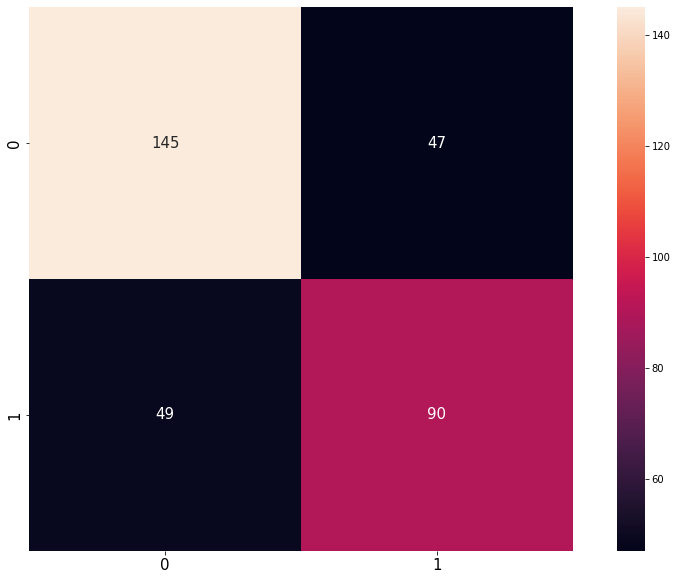

In [10]:
# Confusion matrix
mat = confusion_matrix(decision_tree.predict(test_data_x), test_data_y)

plt.figure(figsize = (16,10))
sns.heatmap(mat, annot=True, annot_kws={'size': 15}, square = True, fmt=".3g")
plt.xticks(size = 15)
plt.yticks(size = 15)


In [11]:
# Most discriminatory features
pd.concat((pd.DataFrame(train_data_x.columns, columns = ['variable']), 
           pd.DataFrame(decision_tree.feature_importances_, columns = ['importance'])), 
          axis = 1).sort_values(by='importance', ascending = False)

,variable,importance
1,Sex,0.297360
2,Age,0.263516
5,Fare,0.201098
0,Pclass,0.134193
3,SibSp,0.059956
4,Parch,0.023870
6,Embarked,0.020006


In [12]:
train_data["Survived"].groupby(train_data["Sex"]).mean()

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

### It seems like the phrase ***"Women and children first"*** is not just a saying, our most sincere respects to them

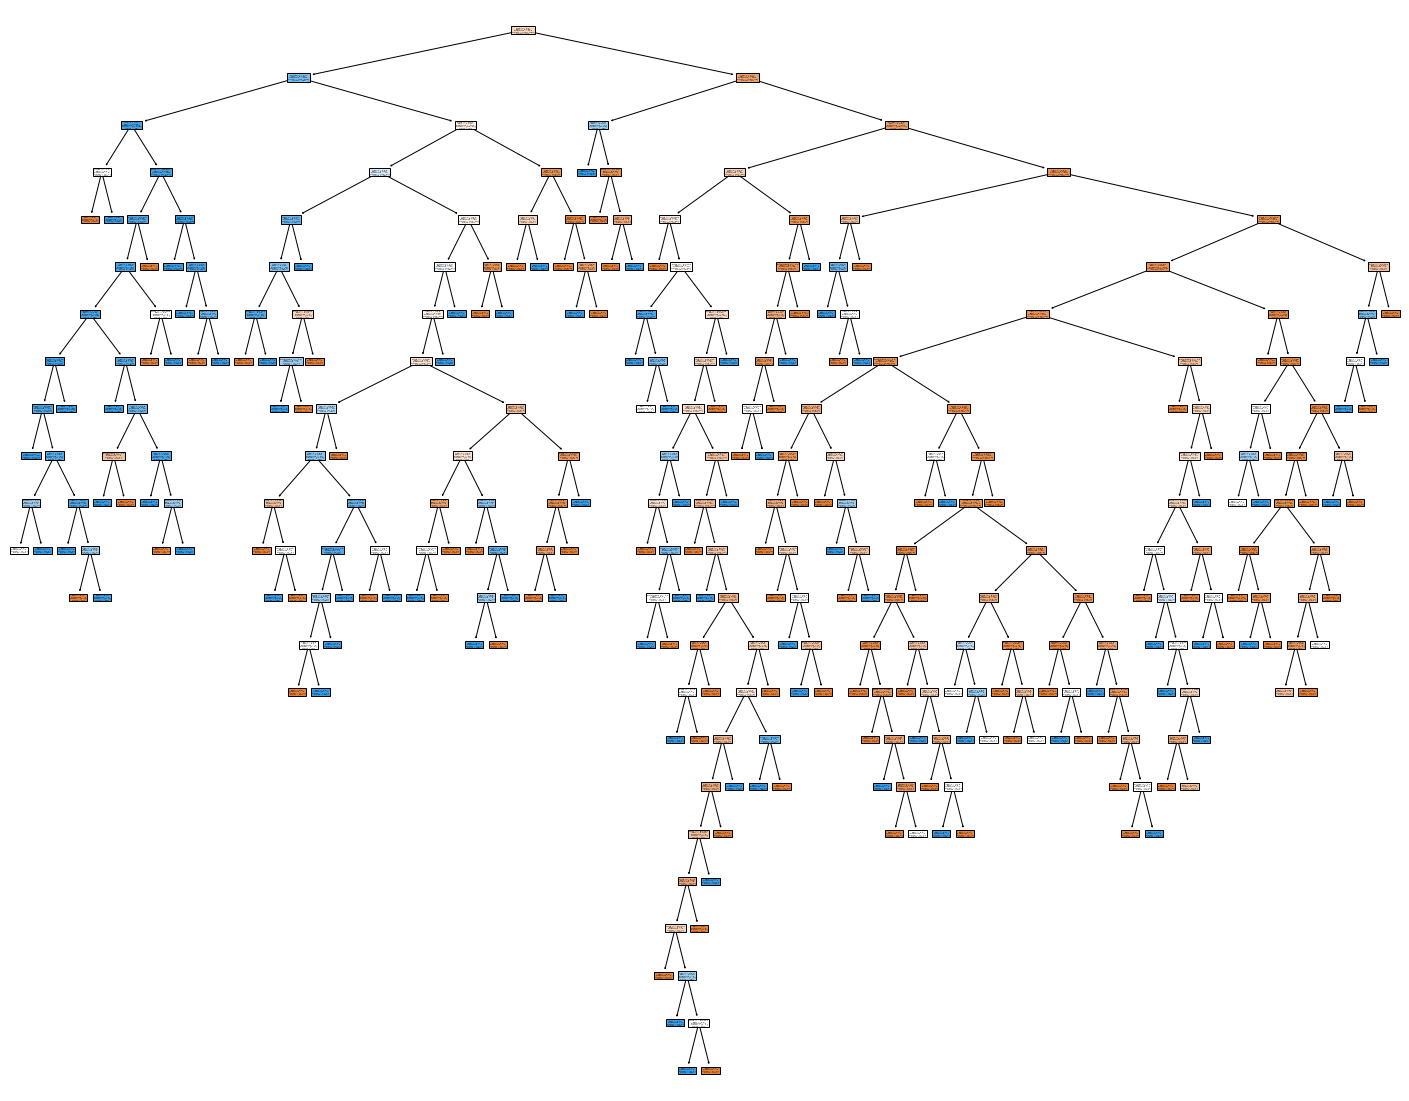

In [13]:
plt.figure(figsize=(25, 20))
_ = plot_tree(decision_tree, feature_names=train_data_x.columns, class_names=["No", "Yes"], filled=True)
plt.savefig("out.svg")

### The tree predicts the survival correctly in *71%*,

which is not bad. However, this could be **better**, note that:
- The dataset is relatively *small*, fewer than 1000. In addition, we removed part of it, making it even smaller.
  - Maybe we can replace the missing values
- We didn't do any hyperparameter tunning (e.g. max_depth, min_samples_split)
  - Try to cross validate
- Decision trees are often overfitting training data, is there any solution?
  - Ensemble methods, e.g. Random Forest